In [1]:
import os

import numpy as np

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATAFRAMES = os.path.join("..", "..", "..", "results", "dataframes", "LFR_subsets", "")
FIGURES = os.path.join("..", "..", "..", "results", "figures", "")

# Data preprocessing

In [3]:
df_DC = pd.read_csv(os.path.join(DATAFRAMES, "..", "dataframe_DC-LFR.csv"))
df_DC["embedding"] = ["DC"]*len(df_DC)
df_DC = df_DC.rename(columns={"pfi": "theta"})
df_DC['params'] = df_DC[["mu", "t1"]].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
df_DC = df_DC.query("theta > 0")
df_DC.head()

,N,t1,mu,theta,auroc,embedding,params
1,10000,4.0,0.1,0.05,0.308707,DC,0.1-4.0
2,10000,4.0,0.1,0.10,0.273467,DC,0.1-4.0
3,10000,4.0,0.1,0.15,0.289533,DC,0.1-4.0
4,10000,4.0,0.1,0.20,0.378105,DC,0.1-4.0
5,10000,4.0,0.1,0.25,0.523219,DC,0.1-4.0


In [4]:
# Load data
dfs = [df_DC]
for ex in ["ex01", "ex03", "ex04", "ex05"]:
    df = pd.read_csv(os.path.join(DATAFRAMES, f"dataframe_{ex}.csv"))
    df["ex"] = [ex]*len(df)  # notate data origin
    params = ""
    match ex:
        case "ex01":
            params = "0.1-2.1"
        case "ex03":
            params = "0.1-4.0"
        case "ex04":
            params = "0.5-2.1"
        case "ex05":
            params = "0.3-2.7"
    df["params"] = [params]*len(df)
    dfs.append(df)

# Concatenate ex01-ex05
df = pd.concat(dfs)
print(df.columns)

Index(['N', 't1', 'mu', 'theta', 'auroc', 'embedding', 'params', 'system',
       't2', 'prob', 'accuracy', 'pr', 'intercept', 'coef_distances',
       'coef_degrees', 'ex'],
      dtype='object')


In [5]:
# Global transformations
df["relative_impact"] = np.abs(df["coef_distances"]) / (np.abs(df["coef_degrees"]) + np.abs(df["coef_distances"]))

In [6]:
# Global melts for easier declarative plotting
df = df.melt(
    id_vars=["embedding", "ex", "params", "theta", "mu", "t1", "intercept", "coef_distances", "coef_degrees", "relative_impact"],
    value_vars=["accuracy", "auroc", "pr"],
    var_name="perftype", value_name="perfval"
).melt(
    id_vars=["embedding", "ex", "params", "theta", "mu", "t1", "perftype", "perfval"],
    value_vars=["intercept", "coef_distances", "coef_degrees", "relative_impact"],
    var_name="featuretype",
    value_name="featureval"
)

In [7]:
df.query("ex=='ex03'").groupby("embedding").count()

,ex,params,theta,mu,t1,perftype,perfval,featuretype,featureval
embedding,,,,,,,,,
HOPE,912,912,912,912,912,912,912,912,912
Isomap,912,912,912,912,912,912,912,912,912
LE,912,912,912,912,912,912,912,912,912
N2V,912,912,912,912,912,912,912,912,912


# Figures

## Performance

In [8]:
df_ = df.query("perftype == 'auroc'")
df_ = df_.query("params not in ['0.2-2.1', '0.3-2.1', '0.4-2.1']")
THETAS = sorted(df_.query("embedding != 'DC'")["theta"].unique())

<Figure size 640x480 with 0 Axes>

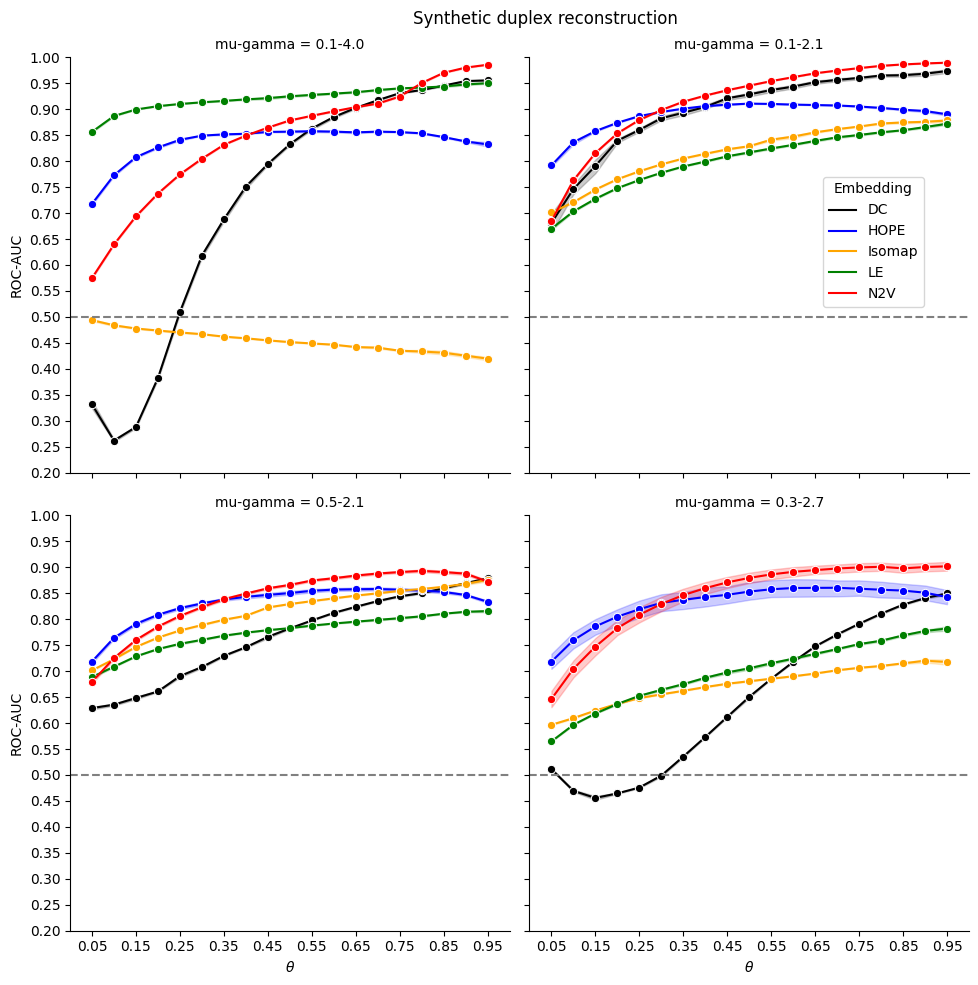

In [10]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_, kind="line",
    x="theta", y="perfval",
    hue="embedding", palette=["black", "blue", "orange", "green", "red"],
    col="params", col_wrap=2,
    marker="o", #style=["--", "-", "-", "-", "-"]
)
g.refline(y=0.5)

# Adjust axes
g.set_axis_labels(r'$\theta$', 'ROC-AUC')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.2, 1), yticks=np.linspace(0.2, 1.0, 17))
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="mu-gamma = {col_name}")
g.fig.subplots_adjust(top=0.9)

# Adjust figure
g.fig.suptitle("Synthetic duplex reconstruction")
sns.move_legend(g,
    loc="upper right", bbox_to_anchor=(0.85, 0.82),
    title="Embedding",
    frameon=True)

# Save to disk
g.tight_layout()
g.savefig(
    os.path.join(FIGURES, "figure_auroc-pfi_hue-embedding_col-ex_data-ex01-thru-ex05.png"),
    transparent=False,
    facecolor="white",
    dpi=600)

## Coefficients

In [11]:
df_ = df_.query("featuretype == 'relative_impact'")
df_["featureval"] = df_["featureval"].apply(lambda x: np.abs(x))

<Figure size 640x480 with 0 Axes>

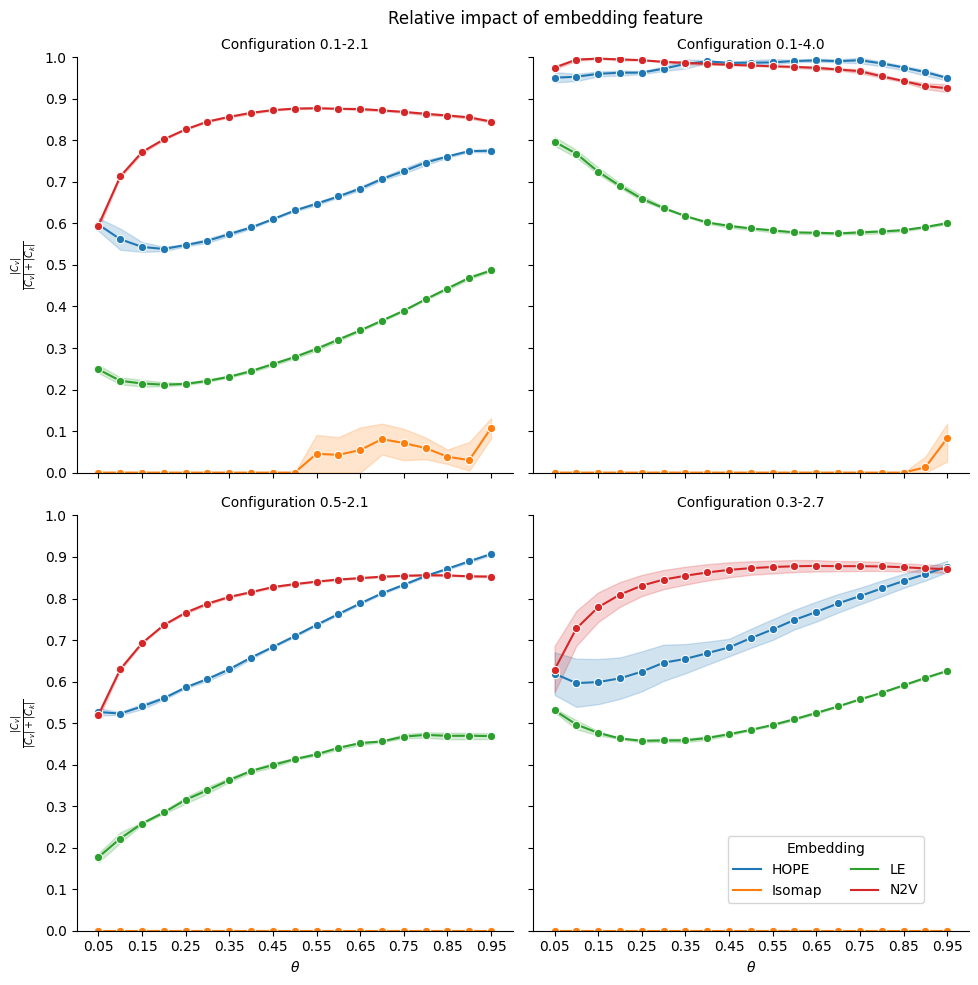

In [13]:
# Instantiate figure
plt.figure()

# Plot data
g = sns.relplot(
    data=df_.query("embedding != 'DC'"), kind="line",
    x="theta", y="featureval",
    hue="embedding",
    # style="featuretype",
    col="params", col_wrap=2,
    marker="o",
)

# Adjust axes
g.set_axis_labels(r'$\theta$', r'$\frac{|C_v|}{|C_v| + |C_k|}$')
g.set(
    xlim=(0,1), xticks=THETAS[::2],
    ylim=(0.0, 1), yticks=np.linspace(0.0, 1.0, 11)
)
g.tick_params(axis="x", labelrotation=00)
g.tick_params(axis="y", which="minor")

# Adjust subplots
g.set_titles(col_template="Configuration {col_name}")
g.fig.subplots_adjust(top=0.9)

# Adjust figure
g.fig.suptitle("Relative impact of embedding feature")
sns.move_legend(g,
    loc="lower right", bbox_to_anchor=(0.85, 0.08),
    title="Embedding",
    ncol=2,
    frameon=True)

# Save to disk
g.tight_layout()
g.savefig(
    os.path.join(FIGURES, "figure_coef-pfi_hue-embedding_col-ex_data-ex01-thru-ex05.png"),
    transparent=False,
    facecolor="white",
    dpi=600)